In this notebook, we attempt to attack GraphRNN. We have one (partial) run of the algorithm (on a smallish dataset): can we infer which samples are in the training set?

In [1]:
import pickle
import numpy as np
import networkx as nx

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Loading training data

Load the outputs that we have carefully generated.

In [3]:
def load_graphs(filename):
    with open(filename, 'rb') as ff:
        return [nx.from_edgelist(l) for l in pickle.load(ff)]

In [4]:
training_graphs = load_graphs('graphrnn/GraphRNN_RNN_custom_multiple_tapas_tu_none_4_128__train_0_edgelist.pkl')
print(len(training_graphs))

100


In [5]:
# Actually, testing = training here? Not 100% sure why. Let's just use training samples and produce fresh tests.

# testing_graphs = load_graphs('graphrnn/GraphRNN_RNN_custom_multiple_tapas_tu_none_4_128__test_0_edgelist.pkl')
# print(len(testing_graphs))

In [6]:
synthetic_graphs = load_graphs('graphrnn/GraphRNN_RNN_custom_multiple_tapas_tu_none_4_128__pred_1000_1_edgelist.pkl')
print(len(synthetic_graphs))

1024


This is the code we used to generate training samples. It can be used to produce fresh testing. samples.

In [7]:
def gen():
    n = np.random.randint(20, 40)
    m = np.random.randint(3, 7)
    return nx.barabasi_albert_graph(n=n, m=m)

In [8]:
def gen_many(N):
    return [gen() for _ in range(N)]

With this, we can divide the test set into "known" training samples and "unknown" ones.

In [9]:
np.random.shuffle(training_graphs)

In [10]:
num_train = 80

positive_train = training_graphs[:num_train]
positive_test = training_graphs[num_train:]

negative_train = gen_many(num_train)
negative_test = gen_many(len(positive_test))

## Attack methodology

Given a graph kernel $k$, a record $G$ and a dataset of synthetic graphs $\tilde{D} = (\tilde{G}_1, \dots, \tilde{G}_m)$, we first compute the feature vector for $G$ as

$$\phi(G) = \left(k(G, \tilde{G}_i)\right)_{i \in [m]} \in \mathbb{R}^m.$$

Then, we must learn a rule to predict whether $G$ was found in the training (private) dataset $D$ used to generate $\tilde{D}$. Ideally, this rule should be relatively simple, as we don't have many training samples. Recall from previous discussions that what we really want is a _score_ that estimates membership probability: $\sigma(\tilde{d}, G) \approx \mathbb{P}[G \in D~|~\tilde{D}=\tilde{d}]$.

Another source of complexity is that the _ordering_ of the graphs in $\tilde{D}$ is arbitrary, and the rule should be symmetrical in the positions of individual synthetic graphs (i.e., permutation invariant). This does not really matter in the train-vs-test setup (maybe it can be helpful for samples tested _on one specific dataset_ to know the position of specific synthetic graphs, and interpret entries of $\phi(G)$ differently), but is crucial to allow the rule learned to generalise to other synthetic datasets!

Here are some options to consider:

1. Simple scores: $min_i \phi_i(G)$, $\frac{1}{m}\sum_i\phi_i(G)$, $perc_{\delta}(\phi(G))$ for $\delta = 0.1$. The rule learned is a simple threshold selected over training samples.
2. Function-of-histogram: first, compute a "histogram" of the values in $\phi(G)$, e.g. 10 bins between a (carefully selected) min and max, $h(\phi(G)) \in \mathbb{R}^k$ for $k \ll m$. Then, learn a function $\sigma_\theta$ of this histogram.
3. Function-of-neighbourhood: a similar idea, using as feature a (sorted) vector of the $k$ highest scores.
4. Machine Learning: learn $\theta$ such that $\sigma_\theta \circ \phi (G) \approx \mathbb{P}[G \in D]$. Note that $\tilde{D}$ is not explicitly referenced in this expression, meaning that this model is unlikely to generalise to other synthetic datasets (informally). In general, it also suffers from the permutation issue.

First, initialise the kernel.

In [11]:
import grakel
from grakel.utils import graph_from_networkx

def _grak(graphs):
    # Add a label to the graphs, for compatibility with grakel.
    for G in graphs:
        # Relabel the graph nodes (useful for the kernel).
        nx.set_node_attributes(G, dict(zip(G.nodes, range(len(G.nodes)))), "label")
    return graph_from_networkx(graphs, node_labels_tag="label")

In [12]:
from grakel import WeisfeilerLehman, VertexHistogram
kernel = WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True)

In [13]:
kernel.fit(_grak(synthetic_graphs))

WeisfeilerLehman(n_iter=4, normalize=True)

Compute the feature vectors.

In [14]:
X_train = kernel.transform(_grak(positive_train + negative_train))
y_train = np.array([True] * len(positive_train) + [False] * len(negative_train))

In [15]:
X_test = kernel.transform(_grak(positive_test + negative_test))
y_test = np.array([True] * len(positive_test) + [False] * len(negative_test))

### 1. Score-based attacks

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

In [17]:
def max_accuracy(true_label, scores):
    fpr, tpr, _ = roc_curve(true_label, scores)
    return np.max((tpr+(1-fpr))/2)

In [18]:
def evaluate_score(scoref):
    score_train = scoref(X_train)
    score_test = scoref(X_test)
    lb = min(score_train.min(), score_test.min())
    ub = max(score_train.max(), score_train.max())
    bins = np.linspace(lb, ub, 21)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.hist(score_train[y_train], bins=bins, facecolor='g', alpha=.5)
    plt.hist(score_train[~y_train], bins=bins, facecolor='r', alpha=.5)
    plt.subplot(1, 3, 2)
    plt.hist(score_test[y_test], bins=bins, facecolor='g', alpha=.5)
    plt.hist(score_test[~y_test], bins=bins, facecolor='r', alpha=.5)
    plt.subplot(1, 3, 3)
    plt.plot([0,1], [0,1], 'k--', alpha=.1)
    fp_train, tp_train, _ = roc_curve(y_train, score_train)
    fp_test, tp_test, _ = roc_curve(y_test, score_test)
    plt.plot(fp_train, tp_train, 'g', label='Train')
    plt.plot(fp_test, tp_test, 'r', label='Test')
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend()

    ev = [('AUC', roc_auc_score), ('Accuracy', max_accuracy)]
    for label, f in ev:
        print(f'Train {label.ljust(8)} ', f(y_train, score_train))
        print(f'Test {label.ljust(8)}  ', f(y_test, score_test))

Train AUC       0.410390625
Test AUC        0.6525000000000001
Train Accuracy  0.5
Test Accuracy   0.625


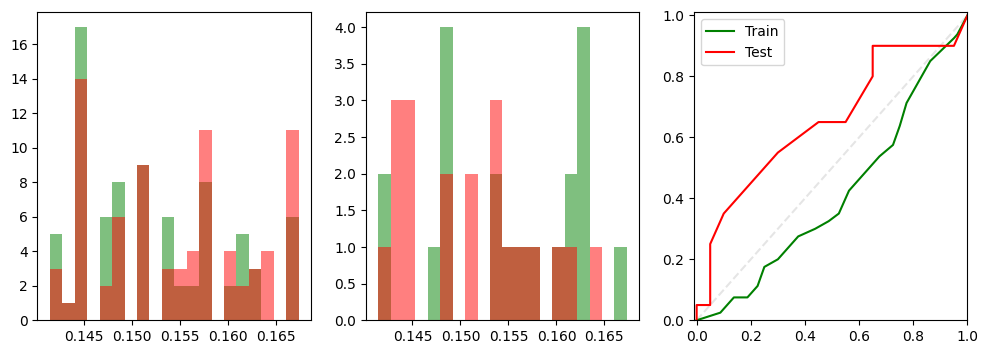

In [19]:
evaluate_score(lambda x: x.min(axis=1))

Train AUC       0.5290625000000001
Test AUC        0.53875
Train Accuracy  0.5625
Test Accuracy   0.625


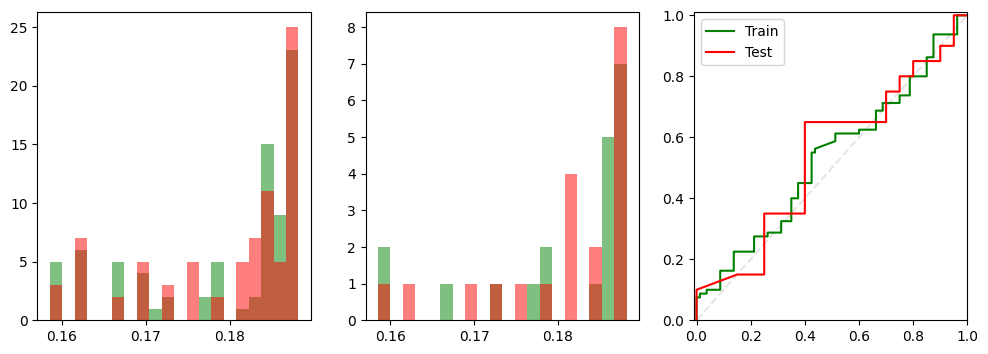

In [20]:
evaluate_score(lambda x: x.mean(axis=1))

Train AUC       0.54453125
Test AUC        0.4575
Train Accuracy  0.575
Test Accuracy   0.525


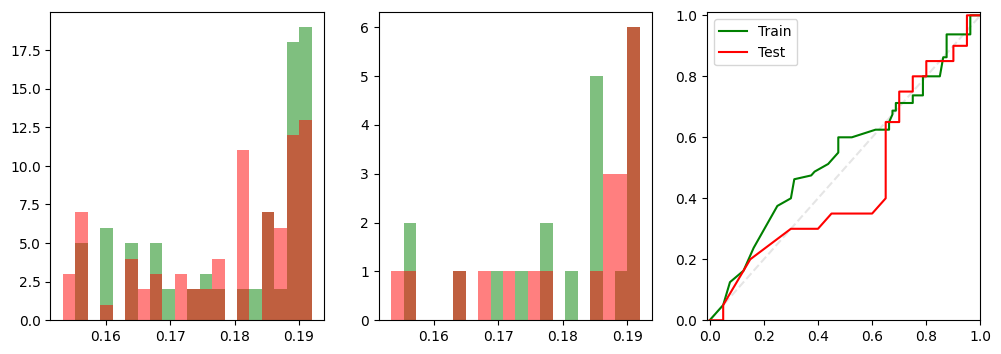

In [21]:
evaluate_score(lambda x: np.median(x, axis=1))

Train AUC       0.930546875
Test AUC        0.905
Train Accuracy  0.90625
Test Accuracy   0.875


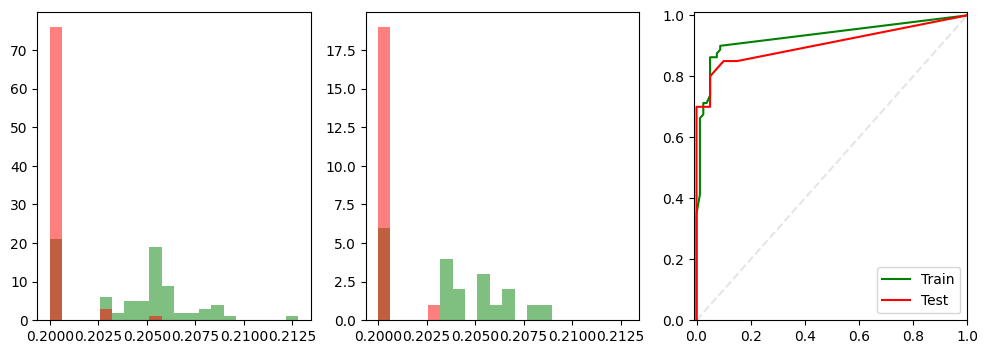

In [22]:
evaluate_score(lambda x: x.max(axis=1))

Train AUC       0.41953125
Test AUC        0.655
Train Accuracy  0.5
Test Accuracy   0.625


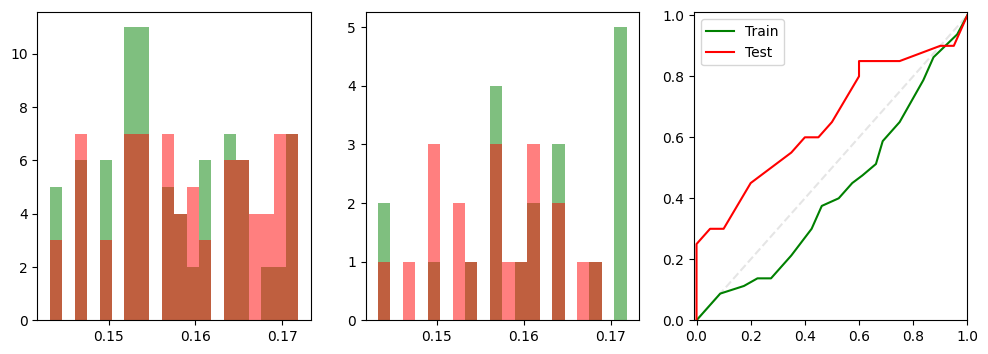

In [23]:
evaluate_score(lambda x: np.percentile(x, 0.95, axis=1))

### 2. Learning-based attacks from histograms

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [25]:
def histogram(X, k, lb=0, ub=1):  # num_entries x num_features
    bins = np.linspace(lb, ub, k+1)
    h = np.zeros((X.shape[0], k))
    for i in range(X.shape[0]):
        h[i,:] = np.histogram(X[i,:], bins=bins)[0]
        h[i,:] = h[i,:] / h[i,:].sum()
    return h

In [26]:
hist = lambda x: histogram(x, lb=0.14, ub=0.22, k=100)

In [27]:
h_train = hist(X_train)
h_test = hist(X_test)

Train AUC       0.64
Test AUC        0.45375
Train Accuracy  0.63125
Test Accuracy   0.55


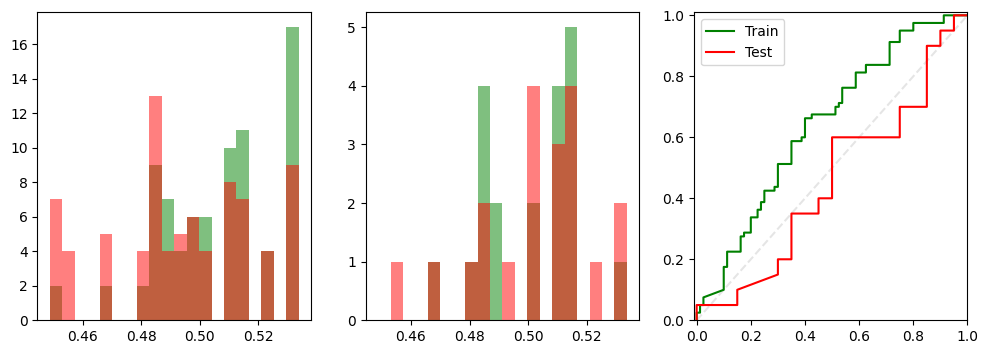

In [28]:
model = LogisticRegression()
model.fit(h_train, y_train)
evaluate_score(lambda x: model.predict_proba(hist(x))[:,1])

Train AUC       0.9984375000000001
Test AUC        0.945
Train Accuracy  0.9875
Test Accuracy   0.925


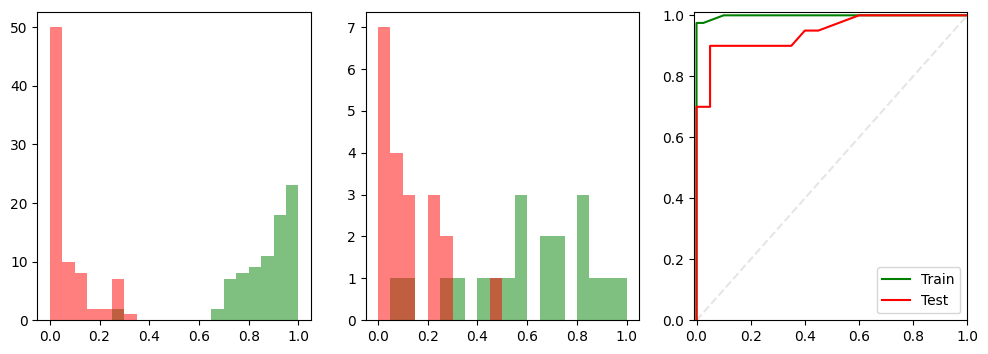

In [29]:
model = RandomForestClassifier()
model.fit(h_train, y_train)
evaluate_score(lambda x: model.predict_proba(hist(x))[:,1])

Pretty bad lol

### 3. Learning-based attack from smallest scores

In [30]:
localize = lambda x: np.sort(x, axis=1)[:,-10:]

Train AUC       0.8721093750000001
Test AUC        0.8287499999999999
Train Accuracy  0.88125
Test Accuracy   0.875


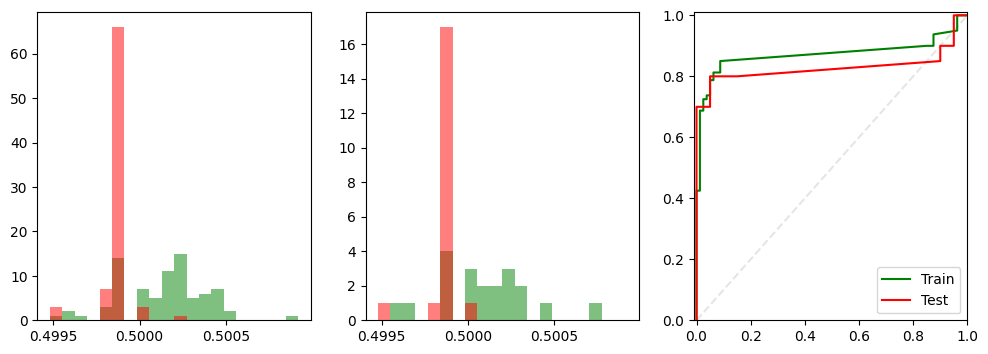

In [31]:
model = LogisticRegression()
model.fit(localize(X_train), y_train)
evaluate_score(lambda x: model.predict_proba(localize(x))[:,1])

This is pretty much as good as taking decisions based on the smallest distance.

Train AUC       0.970859375
Test AUC        0.8762500000000002
Train Accuracy  0.96875
Test Accuracy   0.875


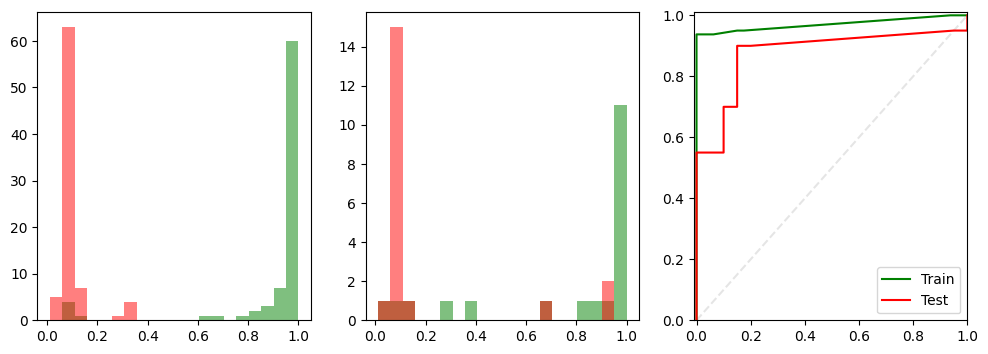

In [32]:
model = RandomForestClassifier()
model.fit(localize(X_train), y_train)
evaluate_score(lambda x: model.predict_proba(localize(x))[:,1])

🥳

### 4. Learning-based attacks without any feature engineering

Train AUC       0.6071874999999999
Test AUC        0.33125
Train Accuracy  0.6
Test Accuracy   0.525


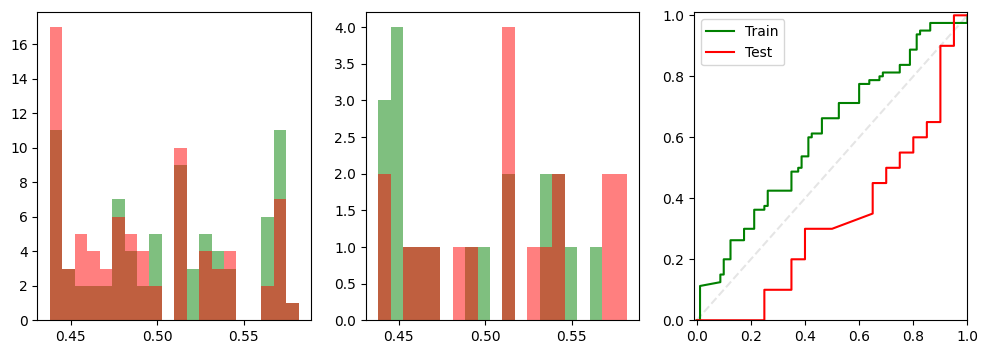

In [33]:
model = LogisticRegression()
model.fit(X_train, y_train)
evaluate_score(lambda x: model.predict_proba(x)[:,1])

Train AUC       0.99875
Test AUC        0.77125
Train Accuracy  0.9875
Test Accuracy   0.75


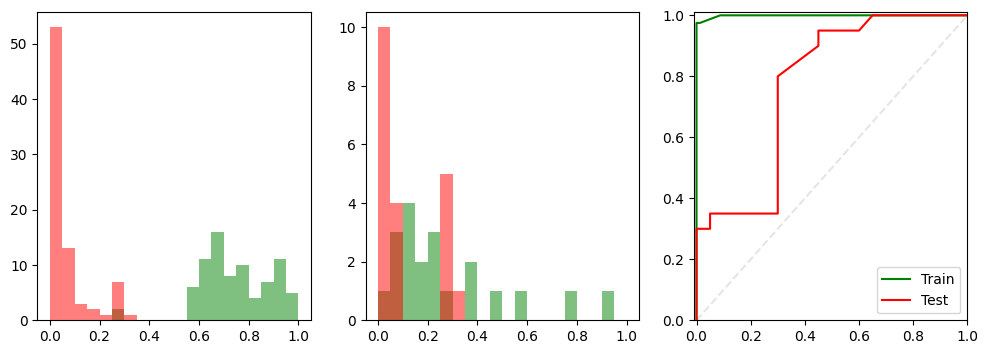

In [34]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
evaluate_score(lambda x: model.predict_proba(x)[:,1])

Train AUC       0.57
Test AUC        0.37625000000000003
Train Accuracy  0.56875
Test Accuracy   0.525


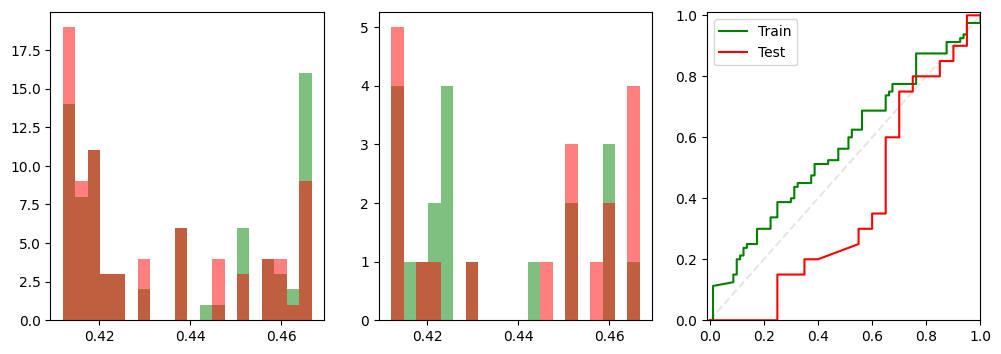

In [35]:
model = MLPClassifier(hidden_layer_sizes=[1000])
model.fit(X_train, y_train)
evaluate_score(lambda x: model.predict_proba(x)[:,1])

This works pretty well _on this dataset_.

---

## Test dataset

We have run GraphRNN on a *second* (completely different) dataset from the same distribution. We will now evaluate the successful attacks on this dataset.

Warning: there will be heavy code re-use in this section. In fact, we will reuse *all* the code from above by swapping X_train and X_test to be the first and second release (rather than subsets of the first release).

First, we rework the `_train` variables to be for the original release.

In [37]:
num_train = len(training_graphs)
X_train = kernel.transform(_grak(training_graphs + gen_many(num_train)))
y_train = np.array([True]*num_train + [False]*num_train)

Second, we load the testing data and use that.

In [38]:
testing_graphs = load_graphs('graphrnn/GraphRNN_RNN_custom_multiple_tapas_tu_test_none_4_128__train_0_edgelist.pkl')
print(len(testing_graphs))

100


In [39]:
synthetic_graphs_2 = load_graphs('graphrnn/GraphRNN_RNN_custom_multiple_tapas_tu_test_none_4_128__pred_1000_1_edgelist.pkl')
print(len(synthetic_graphs_2))

1024


Fit the kernel to extract features.

In [40]:
kernel.fit(_grak(synthetic_graphs_2))

WeisfeilerLehman(n_iter=4, normalize=True)

In [41]:
num_test = len(testing_graphs)
X_test = kernel.transform(_grak(testing_graphs + gen_many(num_test)))
y_test = np.array([True]*num_train + [False]*num_train)

We have to redefine this function to reset internal variables.

In [42]:
def evaluate_score(scoref):
    score_train = scoref(X_train)
    score_test = scoref(X_test)
    lb = min(score_train.min(), score_test.min())
    ub = max(score_train.max(), score_train.max())
    bins = np.linspace(lb, ub, 21)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.hist(score_train[y_train], bins=bins, facecolor='g', alpha=.5)
    plt.hist(score_train[~y_train], bins=bins, facecolor='b', alpha=.5)
    plt.subplot(1, 3, 2)
    plt.hist(score_test[y_test], bins=bins, facecolor='g', alpha=.5)
    plt.hist(score_test[~y_test], bins=bins, facecolor='b', alpha=.5)
    plt.subplot(1, 3, 3)
    plt.plot([0,1], [0,1], 'k--', alpha=.1)
    fp_train, tp_train, _ = roc_curve(y_train, score_train)
    fp_test, tp_test, _ = roc_curve(y_test, score_test)
    plt.plot(fp_train, tp_train, 'g', label='Train')
    plt.plot(fp_test, tp_test, 'b', label='Test')
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend()

    ev = [('AUC', roc_auc_score), ('Accuracy', max_accuracy)]
    for label, f in ev:
        print(f'Train {label.ljust(8)} ', f(y_train, score_train))
        print(f'Test {label.ljust(8)}  ', f(y_test, score_test))

#### Attack 4:  random forest classifier without feature engineering.

Train AUC       0.9992000000000001
Test AUC        0.5367999999999999
Train Accuracy  0.985
Test Accuracy   0.555


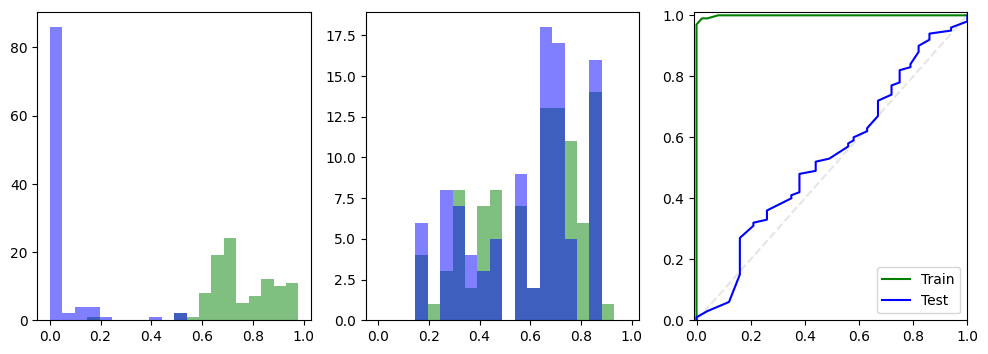

In [43]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
evaluate_score(lambda x: model.predict_proba(x)[:,1])

This attack does not transfer to another dataset, as expected.

#### Attack 2: learning over histograms

Train AUC       0.9991
Test AUC        0.81145
Train Accuracy  0.985
Test Accuracy   0.78


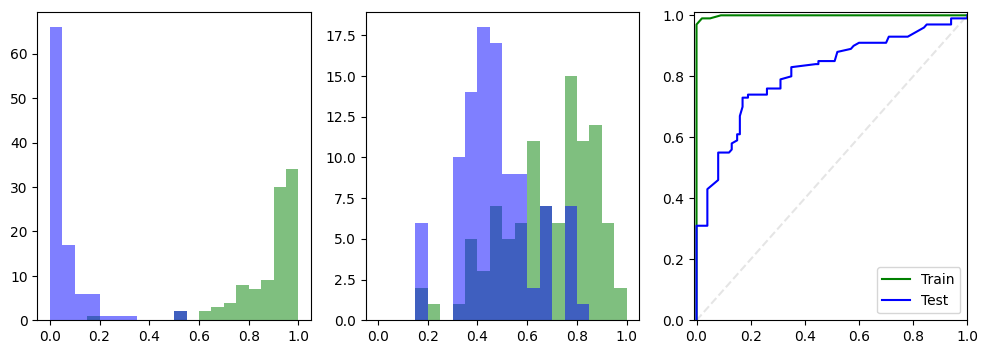

In [44]:
model = RandomForestClassifier()
model.fit(hist(X_train), y_train)
evaluate_score(lambda x: model.predict_proba(hist(x))[:,1])

/usr/local/anaconda3/envs/tapas-dev/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Train AUC       0.9571000000000001
Test AUC        0.5916
Train Accuracy  0.885
Test Accuracy   0.595


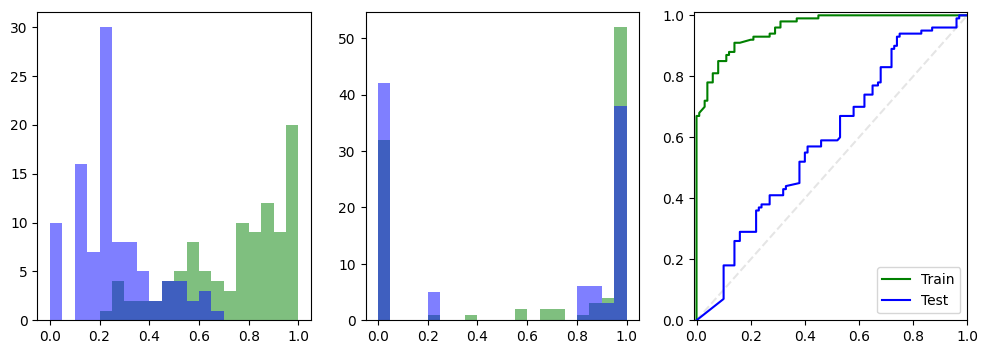

In [45]:
model = MLPClassifier(hidden_layer_sizes=[1000], max_iter=1000)
model.fit(hist(X_train), y_train)
evaluate_score(lambda x: model.predict_proba(hist(x))[:,1])

#### Learning-based over closest neighbours

Train AUC       0.8564
Test AUC        0.7913999999999998
Train Accuracy  0.89
Test Accuracy   0.81


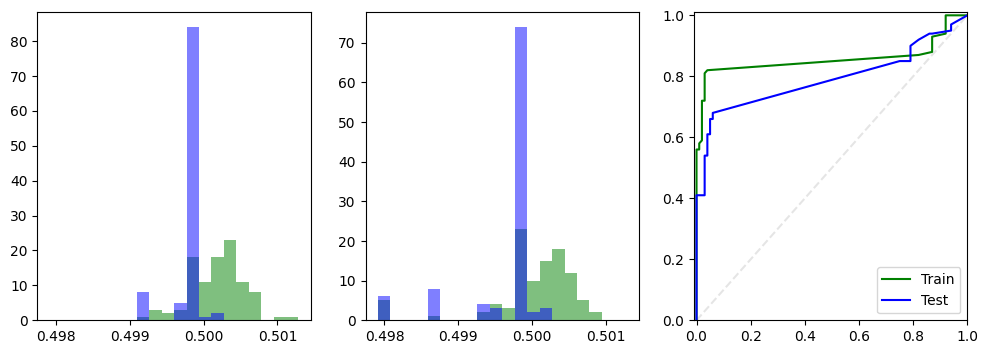

In [46]:
model = LogisticRegression()
model.fit(localize(X_train), y_train)
evaluate_score(lambda x: model.predict_proba(localize(x))[:,1])

Train AUC       0.9714999999999999
Test AUC        0.8373
Train Accuracy  0.9550000000000001
Test Accuracy   0.8200000000000001


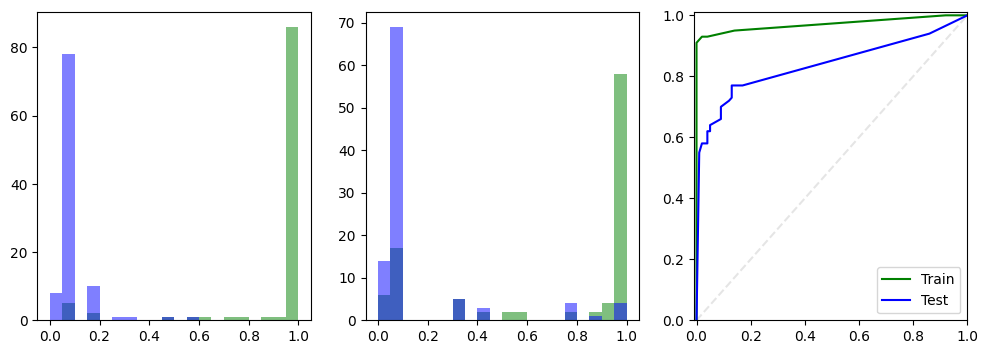

In [47]:
model = RandomForestClassifier()
model.fit(localize(X_train), y_train)
evaluate_score(lambda x: model.predict_proba(localize(x))[:,1])

Train AUC       0.8737
Test AUC        0.7908
Train Accuracy  0.88
Test Accuracy   0.81


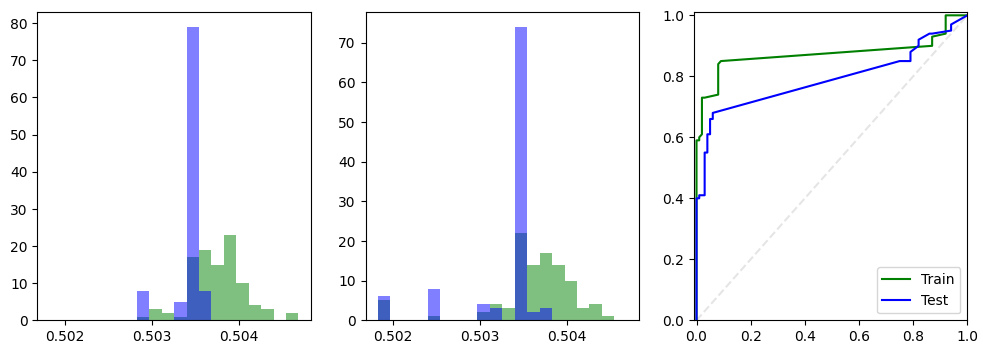

In [48]:
model = MLPClassifier(hidden_layer_sizes=[1000])
model.fit(localize(X_train), y_train)
evaluate_score(lambda x: model.predict_proba(localize(x))[:,1])

#### Attack 1: Score-based from the maximum

Here we do even simpler: no need for all this fancy learning stuff, just extract the score. It works well (better?).

Train AUC       0.92885
Test AUC        0.8315
Train Accuracy  0.925
Test Accuracy   0.835


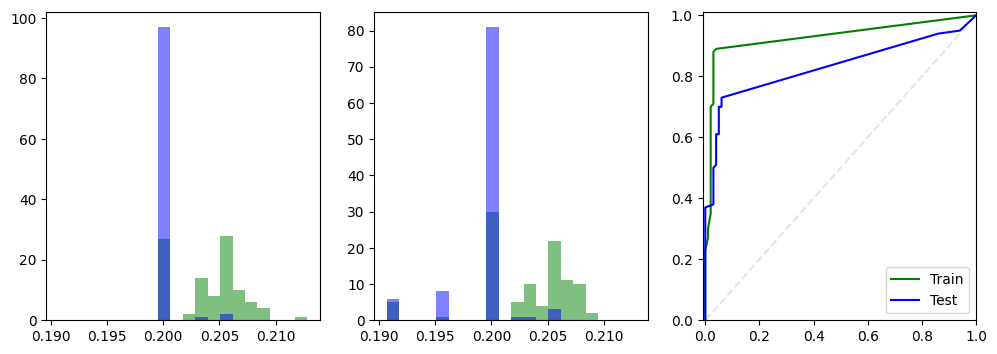

In [49]:
evaluate_score(lambda x: x.max(axis=1))